Описание проекта:
Отчет за прошлый период магазина "В один клик" показал, что активность покупателей начала снижаться. Выходом является удержание активности постоянных клиентов. Предполагается, что сделать это можно засчет персонализированных предложений. 
Задача:
* Разработать модель, которая предскажет вероятность снижения покупательской активности.
* Выделить сегменты покупателей и предложить как увеличить их покупательскую активность.

Компания пердоставила набор данных, который содержит следующие наборы признаков:  
Признаки, которые описывают коммуникацию сотрудников компании с клиентом.  
Признаки, которые описывают продуктовое поведение покупателя.  
Признаки, которые описывабт покупательское поведение клиента.  
Признаки, которые описывают поведение покупателя на сайте.

In [1]:
#pip install -U scikit-learn  # обновление библиотек

In [2]:
#pip install  matplotlib==3.5.0 phik shap

### Шаг 1. Загрузка данных

#### Импорт библиотек

In [3]:
# импорт основных библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import phik
import shap
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
from scipy import stats as st

# импорт библиотек для работы с моделью
from sklearn.preprocessing import StandardScaler # метод масштабирования стандартизация
from sklearn.preprocessing import MinMaxScaler # метод масштабирования нормализация

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder # кодирование данных методом one-hot encoding
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split # для разделения на выборки
from sklearn.linear_model import LinearRegression # для обучения линейной регрессии

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### Загрузка данных

Загружаем данные, используя два типа загрузки - для работы онлайн и оффлайн.

In [4]:
try:
    market_file = pd.read_csv('/Users/dima/first-project/market_file.csv', sep=',', decimal='.') # путь к файлу на компьютере, для работы оффлайн    
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv', sep=',', decimal='.') # если путь к файлу на компьютере не доступен, работа с файлом ведется с сайта яндекса

try:
    market_money = pd.read_csv('/Users/dima/first-project/market_money.csv', sep=',', decimal='.')    
except:
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv', sep=',', decimal='.')
try:
    market_time = pd.read_csv('/Users/dima/first-project/market_time.csv', sep=',', decimal='.')
except:
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', sep=',', decimal='.')
try:
    money = pd.read_csv('/Users/dima/first-project/money.csv', sep=';', decimal=',')
except:
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')

#### Проверка, что данные зарузились и соответствуют описанию

In [5]:
market_file.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
market_money.head(5)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
market_time.head(5)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
money.head(5)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


_<span style='color: green;'>Данные загружены успешно. В трех таблицах разделителем является запятая, а десятичным разделителем точка, в последней таблице разделитель точка с запятой, а десятичный разделитель запятая.</span>_

### Шаг 2. Предобработка данных

#### Переименование колонок

По условию задачи названия колонок можно оставить кириллическими. Но сделаем замену пробелов на _ и уберем большие буквы.

In [9]:
market_file.columns = market_file.columns.str.replace(' ', '_').str.lower()
market_money.columns = market_money.columns.str.lower()
market_time.columns = market_time.columns.str.lower()
money.columns = money.columns.str.lower()

In [10]:
market_file.head(3) # Проверка

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5


In [11]:
market_money.head(3)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


In [12]:
market_time.head(3)

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


In [13]:
money.head(3)

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


_<span style='color: green;'>Названия колонок исправлены.</span>_

#### Проверка данных на пропущенные значения и проверка типов данных.

In [14]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

_<span style='color: green;'>В таблице market_file пропущенных значений нет.</span>_

In [15]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


_<span style='color: green;'>В таблице market_money пропущенных значений нет.</span>_

In [16]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


_<span style='color: green;'>В таблице market_time пропущенных значений нет.</span>_

In [17]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


_<span style='color: green;'>В таблице money пропущенных значений нет.</span>_

#### Проверка данных на явные дубликаты

In [18]:
market_file.duplicated().sum() # посчитаем количество дубликатов

0

In [19]:
market_money.duplicated().sum()

0

In [20]:
market_time.duplicated().sum()

0

In [21]:
money.duplicated().sum()

0

_<span style='color: green;'>Явных дубликатов в данных не обнаружено.</span>_

#### Проверка данных на неявные дубликаты

<u>Таблица market_file</u>

In [22]:
market_file['id'].value_counts()

id
215348    1
216202    1
216220    1
216219    1
216218    1
         ..
215779    1
215778    1
215777    1
215776    1
216647    1
Name: count, Length: 1300, dtype: int64

_<span style='color: green;'>В таблице market_file каждый id встречается один раз.</span>_

In [23]:
for col in market_file.select_dtypes(include='object').columns:
    print('Уникальные значения в столбце', col)
    print(market_file[col].unique())
    print()

Уникальные значения в столбце покупательская_активность
['Снизилась' 'Прежний уровень']

Уникальные значения в столбце тип_сервиса
['премиум' 'стандартт' 'стандарт']

Уникальные значения в столбце разрешить_сообщать
['да' 'нет']

Уникальные значения в столбце популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']



_<span style='color: green;'>В столбце 'тип_сервиса' необходимо исправить 'стандартт' на 'стандарт'.</span>_

In [24]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт') # замена

In [25]:
market_file['тип_сервиса'].unique() # проверка

array(['премиум', 'стандарт'], dtype=object)

<u>Таблица market_money</u>

In [26]:
market_money['id'].value_counts()

id
215348    3
216202    3
216220    3
216219    3
216218    3
         ..
215779    3
215778    3
215777    3
215776    3
216647    3
Name: count, Length: 1300, dtype: int64

_<span style='color: green;'>В таблице каждый id встречается три раза, вероятно, для каждого значения периода.</span>_

In [27]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

<u>Таблица market_time</u>

In [28]:
market_time['id'].value_counts()

id
215348    2
216202    2
216220    2
216219    2
216218    2
         ..
215779    2
215778    2
215777    2
215776    2
216647    2
Name: count, Length: 1300, dtype: int64

_<span style='color: green;'>В таблице каждый id встречается два раза, вероятно, для каждого значения периода.</span>_

In [29]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

_<span style='color: green;'>В данном столбце необходимо переименовать 'предыдцщий_месяц' на 'предыдущий_месяц' для того, чтобы названия в таблицах были согласованы.</span>_

In [30]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц') # замена

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

In [31]:
market_time['период'].unique() 

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

<u>Таблица money</U>

In [32]:
money['id'].value_counts()

id
215348    1
216202    1
216220    1
216219    1
216218    1
         ..
215779    1
215778    1
215777    1
215776    1
216647    1
Name: count, Length: 1300, dtype: int64

_<span style='color: green;'>В таблице каждый id встречается один раз.</span>_

На всякий случай еще раз проверим явные дубликаты в таблицах, где исправляли неявные.

In [33]:
market_file.duplicated().sum() # посчитаем количество дубликатов

0

In [34]:
market_time.duplicated().sum()

0

<span style='color: green;'>

Выводы:
* Были скорректированы имена столбцов - убраны большие буквы и пробелы.
* Пропущенных значений в данных обнаружено не было.
* Явных дубликатов в данных обнаружено не было.
* Типы данных корректны.
* В таблице market_file были обнаружены неявные дубликаты - исправлены.
* Обнаружено несоответствие между названиями периодов в таблицах market_money и market_time - исправлено.

</span>

### Шаг 3. Исследовательский анализ данных

#### Изучим распределения данных

Для количественных данных построим гистограммы распределения.

In [35]:
def plot_histogram(dataframe, column_name, bins=10):  # функция для построения гистограмм распределения
    dataframe[column_name].hist(bins=bins, figsize=(8, 8))
    plt.xlabel(column_name)
    plt.ylabel('Частота')
    plt.show()
    

Для изучения качественных данных будем использовать столбчатую диаграмму.

In [36]:
def plot_bar(dataframe, column_name):  # функция для построения столбчатой диаграммы
    fig, ax = plt.subplots()
    unique_values = dataframe[column_name].unique()
    value_counts = dataframe[column_name].value_counts()
    
    ax.bar(unique_values, value_counts[unique_values])
    ax.set_xlabel(column_name)
    ax.set_ylabel('Количество')
    plt.xticks(rotation=45, ha='right')
    plt.show()

<u>Таблица market_file</u>

Изучим основные статистические параметры данных в таблице market_file.

In [37]:
market_file.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


_<span style='color: green;'>Вероятно, распределения всех признаков приближаются к нормальному, так как среднее и медиана почти совпадают. На первый взгляд каких-либо значительных выбросов данных не видно, за исключением количества неоплаченных товаров в корзине за 3 месяца, при среднем и медиане в районе 3, есть значения 10, и в столбце среднее количество страниц за визит максимальное число составляет 20 при среднем и медиане 8. </span>_

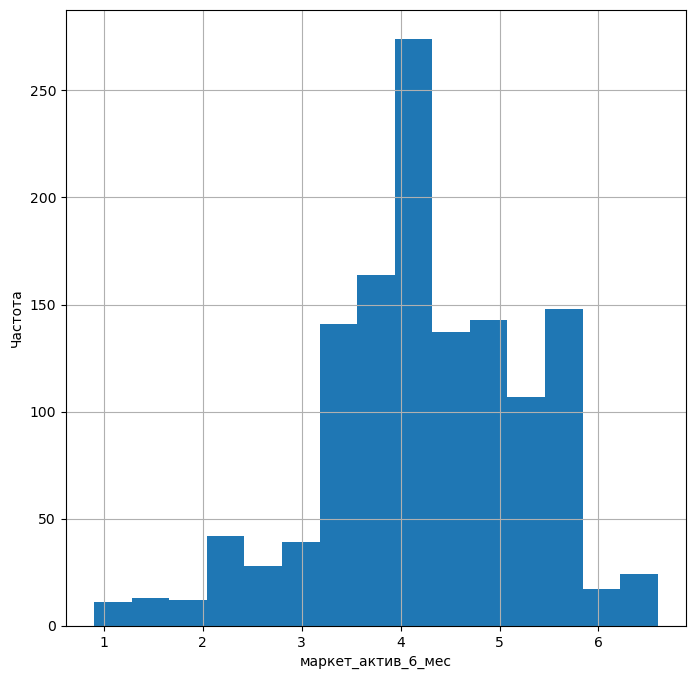

In [38]:
plot_histogram(market_file, 'маркет_актив_6_мес', bins=15)

_<span style='color: green;'>Среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев составляет от 0.9 до 6.6, в среднем 4.</span>_

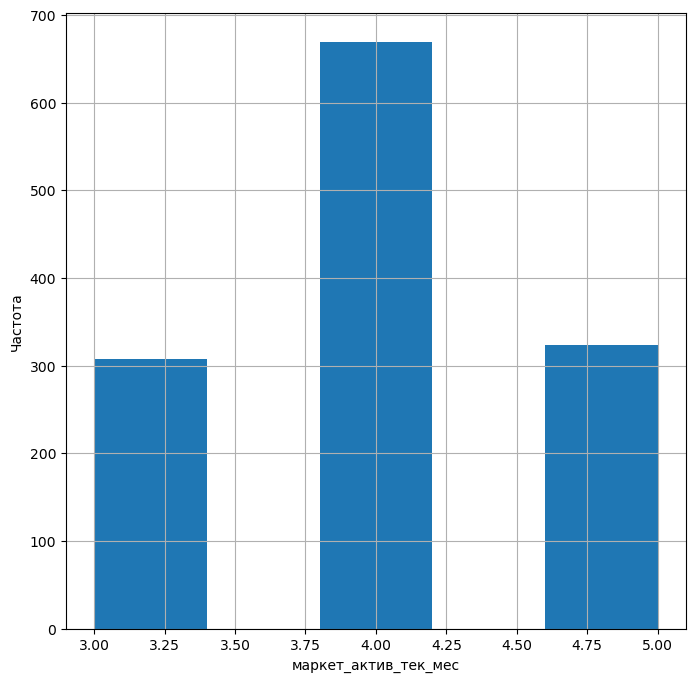

In [39]:
plot_histogram(market_file, 'маркет_актив_тек_мес', bins=5)

In [40]:
market_file['маркет_актив_тек_мес'].unique()

array([5, 4, 3])

_<span style='color: green;'>Количество маркетинговых коммуникаций в текущем месяце ('маркет_актив_тек_мес') содержит только три значения 5, 4 и 3.</span>_

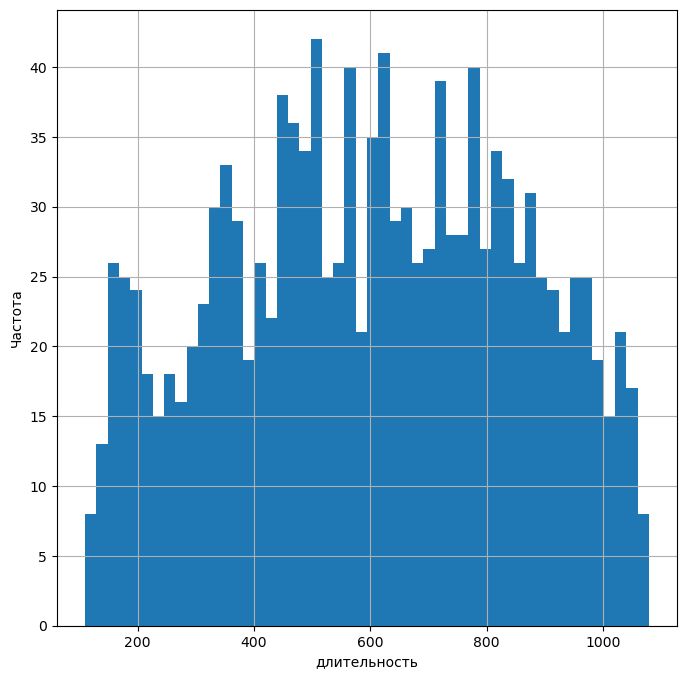

In [41]:
plot_histogram(market_file, 'длительность', bins=50)

_<span style='color: green;'>Минимальное значение количества дней с момента регистрации составляет 110, а максимальное 1079 дней. Среднее значение составляет 602.</span>_

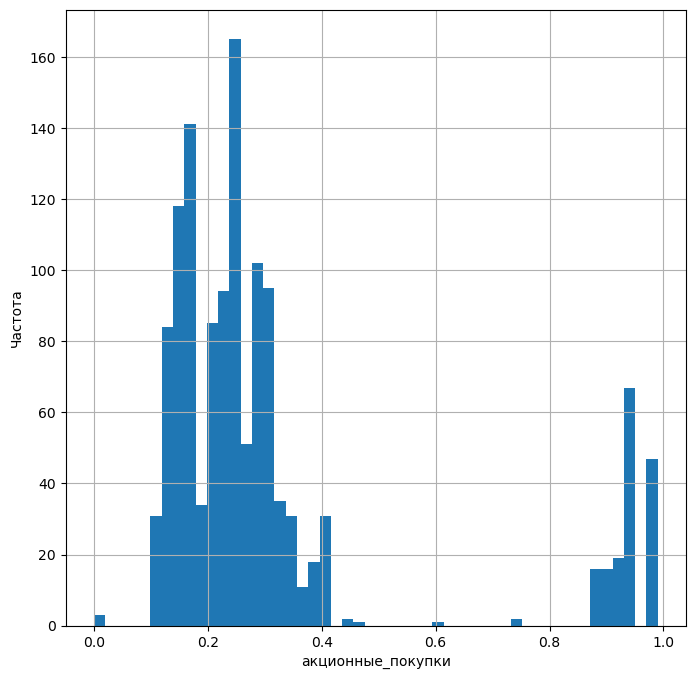

In [42]:
plot_histogram(market_file, 'акционные_покупки', bins=50)

_<span style='color: green;'>Распределение среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев имеет две части. Большая часть данных приходятся на значения от приблизительно 0.1 до 0.5, но есть второй максимум в диапазоне от 0.8 до 1.</span>_

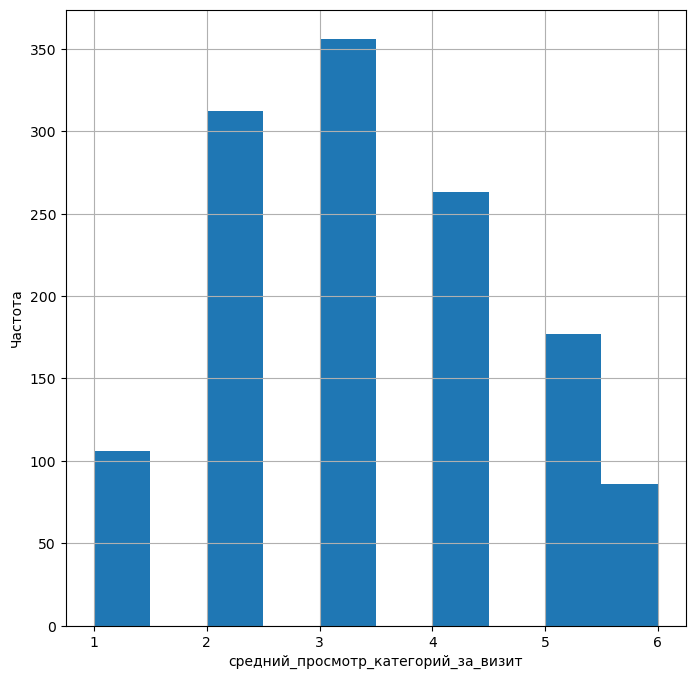

In [43]:
plot_histogram(market_file, 'средний_просмотр_категорий_за_визит', bins=10)

In [44]:
market_file['средний_просмотр_категорий_за_визит'].unique()

array([6, 4, 5, 3, 2, 1])

_<span style='color: green;'>Данные о  том, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца,содержат 6 значений. Такие количественне данные можно превратить в категориальные, чтобы использовать в модели.</span>_

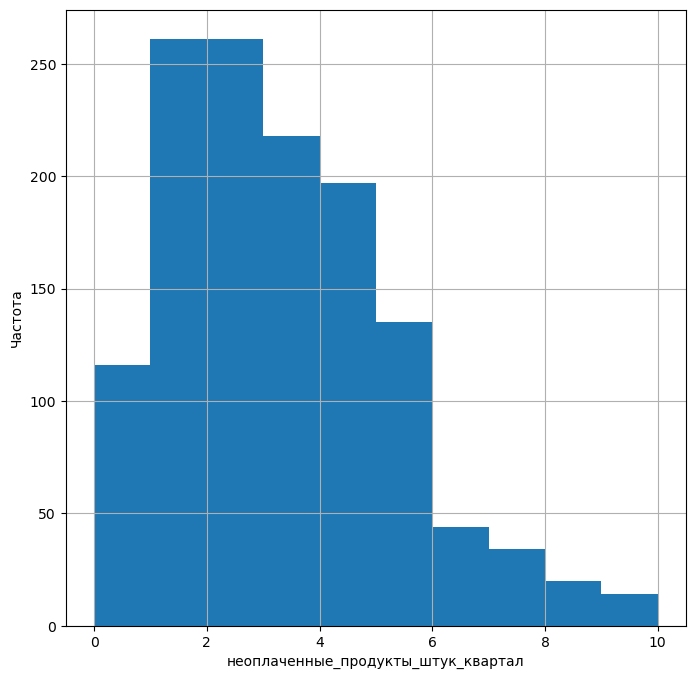

In [45]:
plot_histogram(market_file, 'неоплаченные_продукты_штук_квартал', bins=10)

_<span style='color: green;'>Распределение неоплаченных товаров скошено вправо. Максмимум приходится на 2 - 3 шт.</span>_

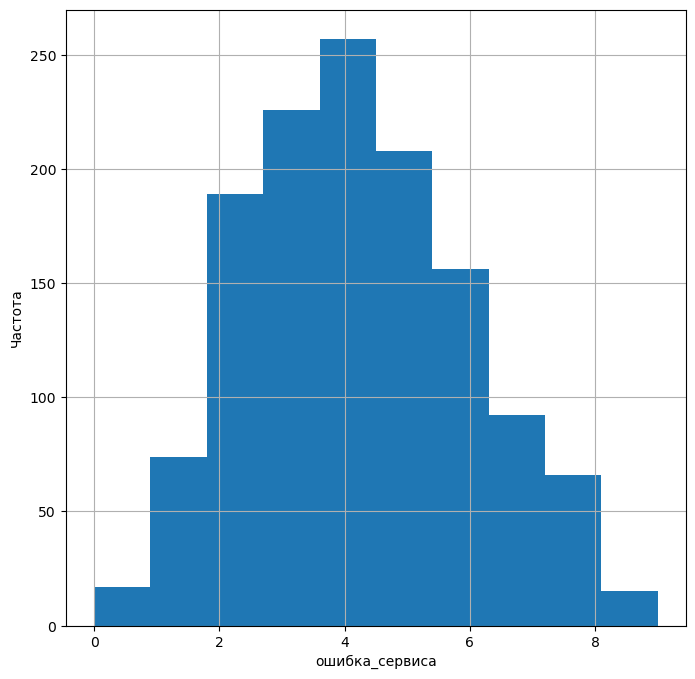

In [46]:
plot_histogram(market_file, 'ошибка_сервиса', bins=10)

_<span style='color: green;'>Число сбоев распределено нормально от 0 до 9. Максимум распределения приходится на 4 сбоя.</span>_

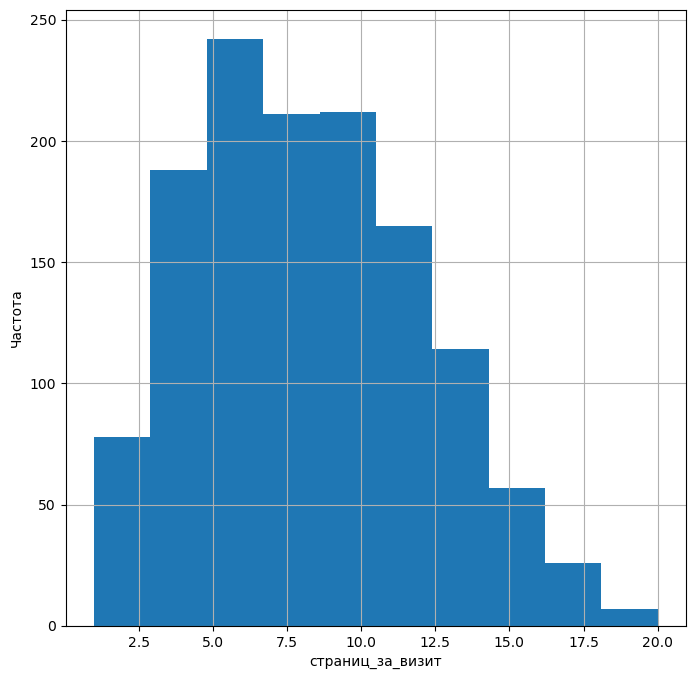

In [47]:
plot_histogram(market_file, 'страниц_за_визит', bins=10)

Изучим качественные признаки в таблице market_file

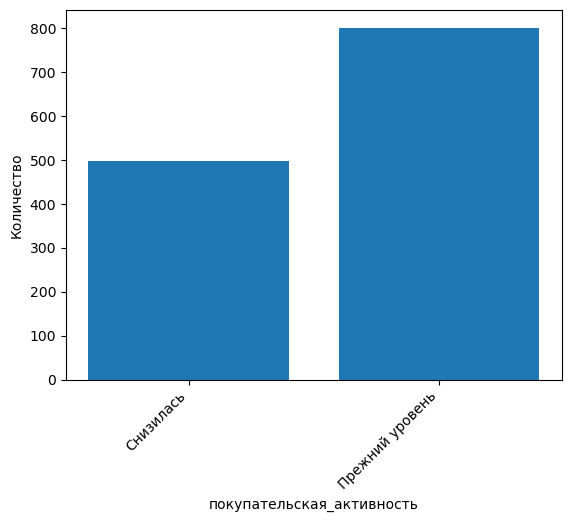

In [48]:
plot_bar(market_file, 'покупательская_активность')

_<span style='color: green;'>Покупательская активность является целивым признаком, в данных более предствалены клиенты, у которых покупательская активность осталась на прежнем уровне. Такой разрыв в данных говорит нам о том, что при разбивке выборки на группы для обучения модели, необходимо использовать стратификацию данных.</span>_

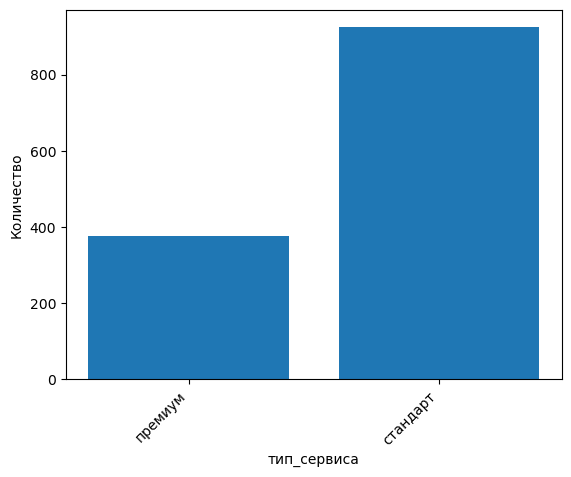

In [49]:
plot_bar(market_file, 'тип_сервиса')

_<span style='color: green;'>В данных более представлен стандартный тип сервиса</span>_

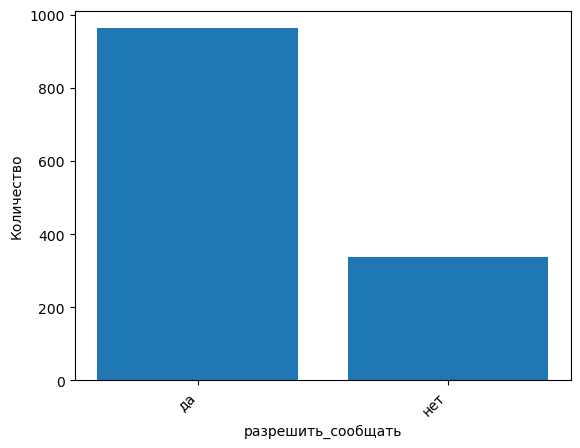

In [50]:
plot_bar(market_file, 'разрешить_сообщать')

_<span style='color: green;'>Большая часть клиентов в данных разрешила присылать им дополнительную информацию. </span>_

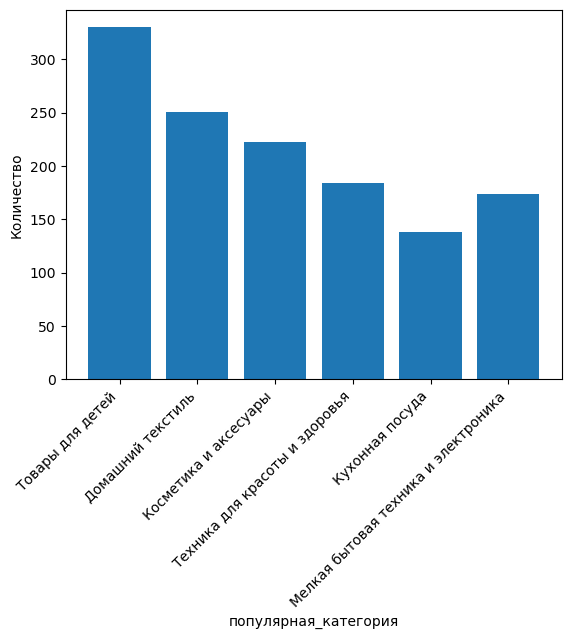

In [51]:
plot_bar(market_file, 'популярная_категория')

_<span style='color: green;'>Наиболее популярными в данных являются товары для детей, меньше всего представлена кухонная посуда.</span>_

<u>Таблица market_money</u>

In [52]:
market_money.describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


_<span style='color: green;'>Среднее значение и медиана составляют примерно 5000. Максимальное значение составляет 107 тыс, а в данных явно есть выбросы.</span>_

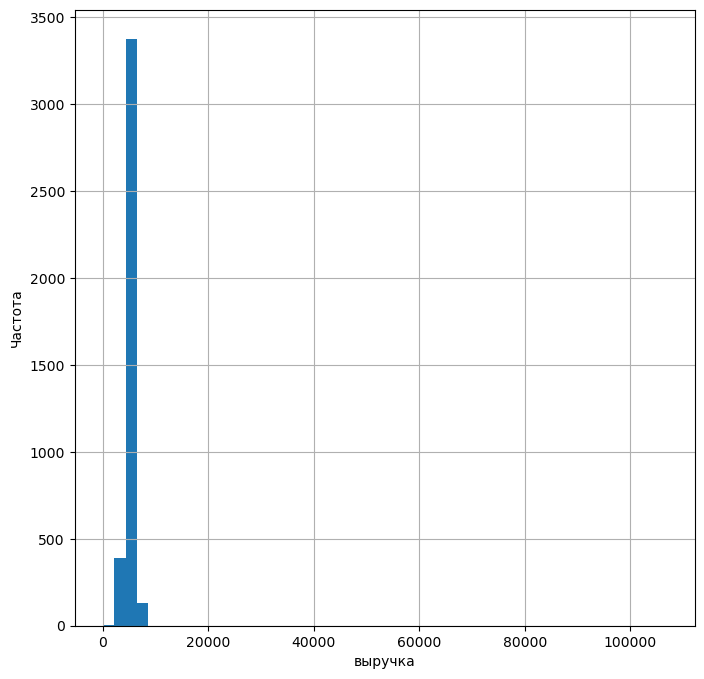

In [53]:
plot_histogram(market_money, 'выручка', bins=50)

_<span style='color: green;'>Из гистограммы также видно, что есть выброс. Изучим его подробнее.</span>_

In [54]:
market_money.loc[market_money.loc[:,'выручка'] > 20000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


Значение выручки очень странное, заменим это значение средним за предпредыдущий и предыдущий месяц у этого клиента.

In [55]:
market_money.loc[market_money.loc[:,'id'] == 215380]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


In [56]:
market_money.loc[98, 'выручка'] = 5564

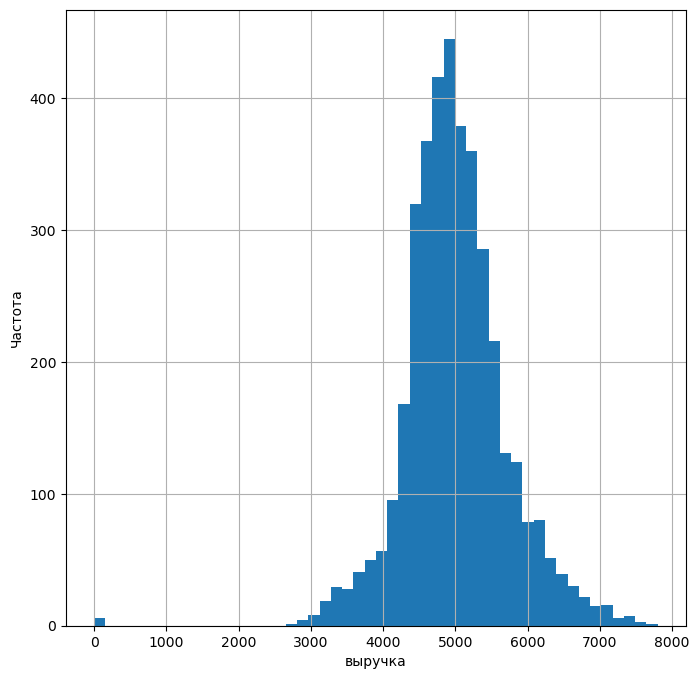

In [57]:
plot_histogram(market_money, 'выручка', bins=50)

В таблице также есть очень малые значения выручки, изучим строки с этими данными.

In [58]:
market_money.loc[market_money.loc[:,'выручка'] < 1000]

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


_<span style='color: green;'>Покупатели с id 215348, 215357, 215359 не совершали покупок в препредыдущий и предыдущий месяц, выручка от них составляет 0. По условию задачи клиентов, которые ничего не купили хотя бы в один из трех месяцев необходимо исключить из дальнейшего анализа. </span>_

Удалим этих клиентов из данных и снова изучим распределение. Удаляем не только предпредыдущий и предыдущий месяц, но и текущий.

In [59]:
market_money = market_money[~market_money['id'].isin([215348, 215357, 215359])]

In [60]:
market_money = market_money.reset_index()

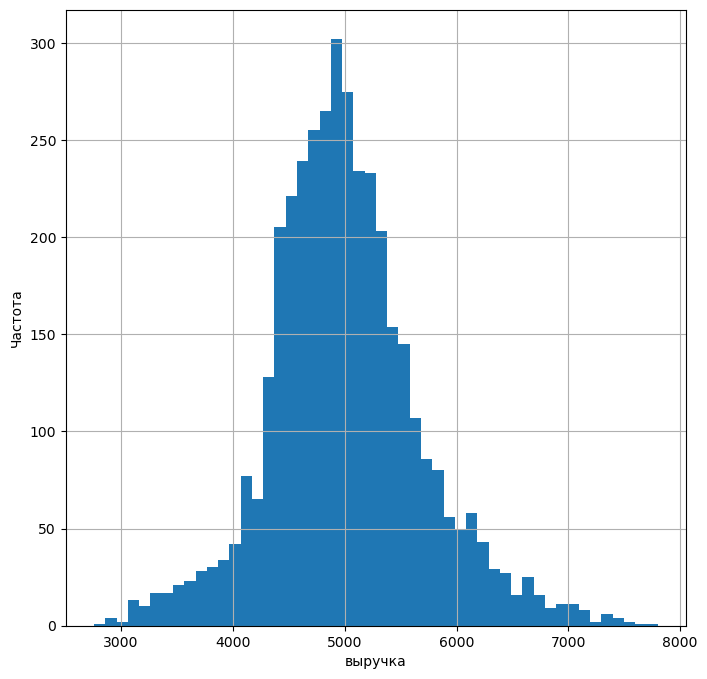

In [61]:
plot_histogram(market_money, 'выручка', bins=50)

_<span style='color: green;'>Распределение выручки по клиентам соответствует нормальному распределению.</span>_

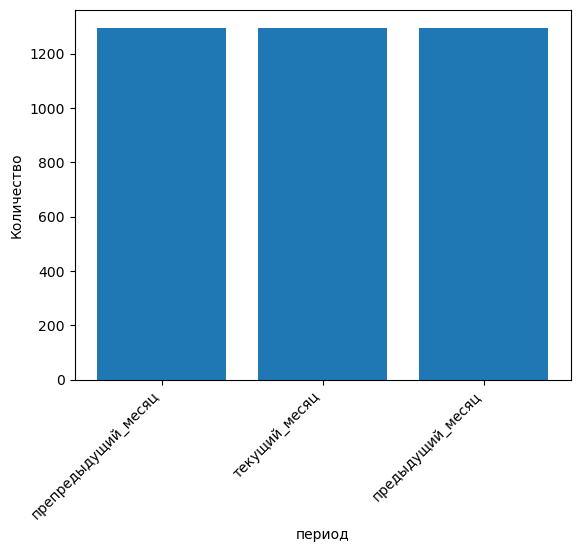

In [62]:
plot_bar(market_money, 'период')

_<span style='color: green;'>В таблице одинаково представлены все периоды.</span>_

<u>Таблица market_time</u>

In [63]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


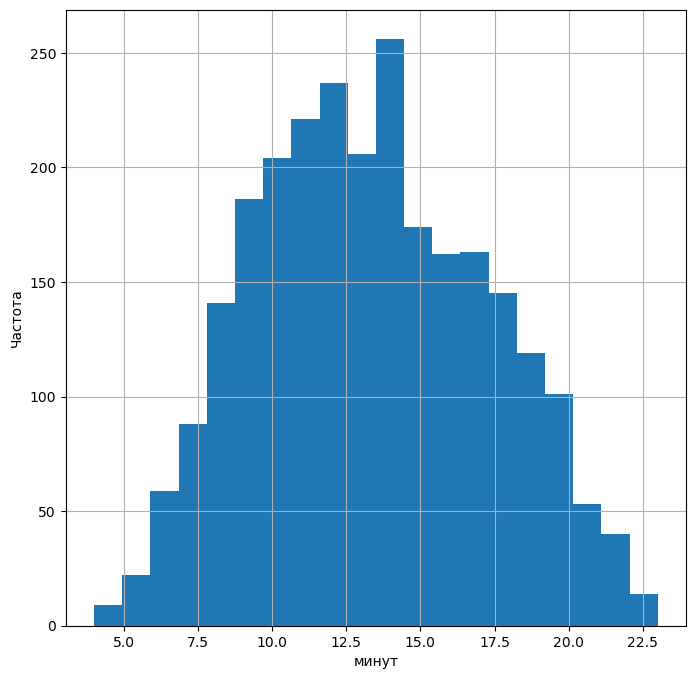

In [64]:
plot_histogram(market_time, 'минут', bins=20)

_<span style='color: green;'>Данные по минутам, проведенным на сайте, распределены нормально. Среднее время, проведенное на сайте 13 минут.</span>_

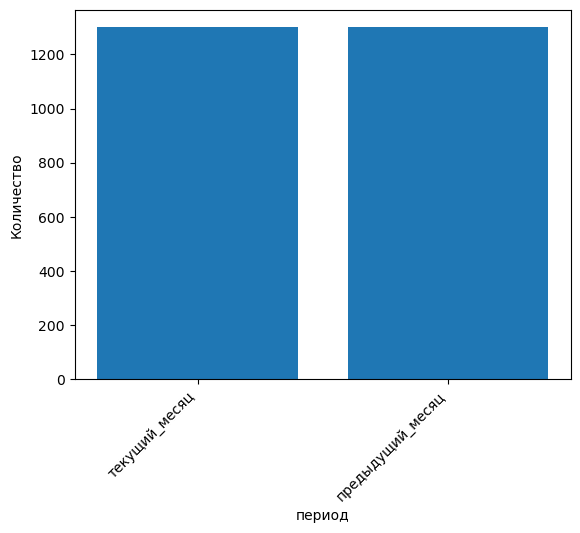

In [65]:
plot_bar(market_time, 'период')

_<span style='color: green;'>В таблице market_time есть данные только за текущий месяц и предыдущий месяц.</span>_

<u>Таблица money</U>

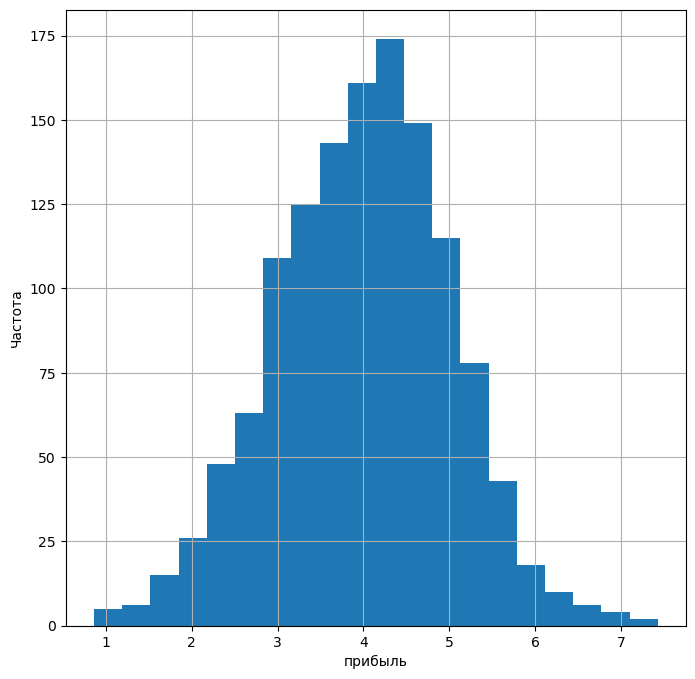

In [66]:
plot_histogram(money, 'прибыль', bins=20)

<span style='color: green;'>

Выводы:
* Проанализированы все количественные и все категориальные признаки трех таблиц.
* В таблице market_file были обнаружены количественные данные, которые принимают ограниченное количество значений (маркет_актив_тек_мес, средний_просмотр_категорий_за_визит) это важно будет учесть при кодировании этих переменных. Возможно, эти количественные признаки имеет смысл перевести в категориальные.
* Целевой признак покупательская активность представлен в данных неравномерно. При разделении данных перед обучением модели необходимо использовать стратификацию.
* В таблице market_money был обнаружен выброс. Кроме того, используя данные о выручке, были удалены клиенты, которые не совершали покупок хотя бы в один из трех месяцев.
* В таблице market_time представлены данные только за два периода.

</span>

Перед объединением таблиц удалим во всех таблицах обнаруженных ранее клиентов с нулевой выручкой.

In [67]:
market_file = market_file[~market_file['id'].isin([215348, 215357, 215359])].reset_index()
market_time = market_time[~market_time['id'].isin([215348, 215357, 215359])].reset_index()
money = money[~money['id'].isin([215348, 215357, 215359])].reset_index()

### Шаг 4. Объединение таблиц

Объединение таблиц будет сделано по столбцу 'id'. В условиях задачи сказано: в итоговой таблице необходимо сделать отдельный столбец для каждого периода. Исходя из этого, сформируем сводные таблицы из market_money и market_time.

In [68]:
pivot_market_money = market_money.pivot_table(index='id', columns='период', values='выручка') # сводная таблица
pivot_market_money.columns = ['предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка'] # переименование столбцов

In [69]:
pivot_market_money.head(5) # проверка

,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


In [70]:
pivot_market_time = market_time.pivot_table(index='id', columns='период', values='минут')
pivot_market_time.columns = ['предыдущий_месяц_минут', 'текущий_месяц_минут']

In [71]:
pivot_market_time.head(5)

,предыдущий_месяц_минут,текущий_месяц_минут
id,,
215349,12.0,10.0
215350,8.0,13.0
215351,11.0,13.0
215352,8.0,11.0
215353,10.0,10.0


In [72]:
df_m_t = pd.merge(pivot_market_money, pivot_market_time, left_index=True, right_index=True) # объединим две сводные таблицы

In [73]:
df_m_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   предыдущий_месяц_выручка     1297 non-null   float64
 1   препредыдущий_месяц_выручка  1297 non-null   float64
 2   текущий_месяц_выручка        1297 non-null   float64
 3   предыдущий_месяц_минут       1297 non-null   float64
 4   текущий_месяц_минут          1297 non-null   float64
dtypes: float64(5)
memory usage: 60.8 KB


Сделаем индексами id клиента в таблице market_file.

In [74]:
market_file.set_index('id', inplace=True, drop=True) 

Объединим все в финальную таблицу по id клиента.

In [75]:
df= pd.merge(market_file, df_m_t, left_index=True, right_index=True)

In [76]:
df.head(5) # проверка

,index,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
id,,,,,,,,,,,,,,,,,,
215349,1,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
215350,2,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
215351,3,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
215352,4,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
215353,5,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0


In [77]:
df.drop(columns=['index'], inplace=True) # удалим ненужный столбец. Не очень понятно, почему drop=True ранее не сработал

In [78]:
df.info() # проверка

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1297 non-null   object 
 1   тип_сервиса                          1297 non-null   object 
 2   разрешить_сообщать                   1297 non-null   object 
 3   маркет_актив_6_мес                   1297 non-null   float64
 4   маркет_актив_тек_мес                 1297 non-null   int64  
 5   длительность                         1297 non-null   int64  
 6   акционные_покупки                    1297 non-null   float64
 7   популярная_категория                 1297 non-null   object 
 8   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  ошибка_сервиса                       1297 non-null   int64  
 11  страниц_за_визит            

На основе количественного признака средний просмотр категорий за визит, который принимает ограниченное количество значений, создадим категориальные переменные:

от 1 до 2 - мало
от 2 до 4 - средне
от 4 до 6 - много

In [79]:
df['просмотр_категорий_за_визит'] = pd.cut(df['средний_просмотр_категорий_за_визит'],
                                           bins=[0,2,4,6],
                                           labels=['мало', 'средне', 'много'],
                                           right=True)

**Данный код был добавлен после того, как предыдущая разбивка показала плохую корреляцию с целевым признаком.  
Другой вариант разбивки на категории:  
 1, 2 - мало  
 3 - средне  
 4, 5, 6 - много

In [80]:
def categorize_value(value):
    if value in [1, 2]:
        return 'мало'
    elif value in [3]:
        return 'средне'
    elif value in [4, 5, 6]:
        return 'много'
    else:
        return None 
df['2_просмотр_категорий_за_визит'] = df['средний_просмотр_категорий_за_визит'].apply(categorize_value)

In [81]:
df.head(10) # проверка

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,просмотр_категорий_за_визит,2_просмотр_категорий_за_визит
id,,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0,средне,много
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0,много,много
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0,много,много
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0,средне,средне
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0,средне,много
215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11.0,12.0,мало,мало
215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12.0,10.0,много,много
215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6.0,7.0,мало,мало
215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14.0,10.0,средне,много


### Шаг 5. Корреляционный анализ

Для корреляционного анализа воспользуемся библиотекой phik, она позволит нам сразу увидеть взаимосвязь всех признаков.

In [82]:
phik_overview = df.phik_matrix(interval_cols=['маркет_актив_6_мес', ' маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка', 'предыдущий_месяц_минут', 'текущий_месяц_выручка_минут'])


Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/Users/dima/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/phik/phik.py:199: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  datahist = data_binned.groupby([c0, c1])[c0].count().to_frame().unstack().fillna(0)
/Users/dima/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/phik/phik.py:199: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
 

The figure layout has changed to tight


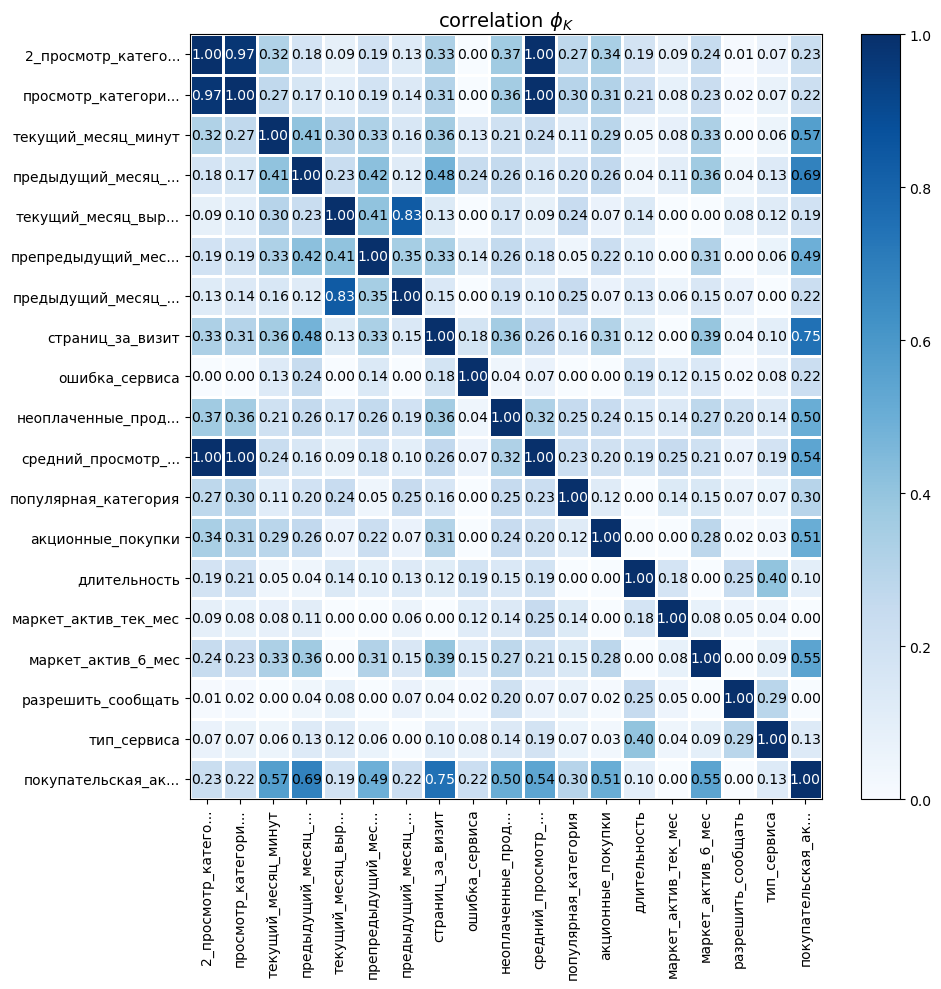

In [83]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1,
    figsize=(10,10)
)
plt.tight_layout()

<span style='color: green;'>
Наибольшая корреляция между входными признаками наблюдается для выручки за текущий и предыдущий месяц, коэффициент корреляции составляет 0.83. Данное значение меньше принятого за порог мультиколлинеарности, поэтому оставим этот признак в данных. Остальные коэффициенты корреляции меньше, таким образом можно сделать вывод, что в данных мультиколлинеарность отсутствует.  
Два признака (Маркет_актив_тек_мес и разрешить_сообщать) показывают почти нулевую корреляцию с целевым признаком покупательская активность. Такие признаки можно исключить из дальнейшей модели.  
    
Лучшую корреляцию с целевым признаком имеют следующие признаки: среднее количество страниц, которое просмотрел покупатель за один визит (страниц за визит); количество минут, проведенных на сайте в предыдущий и в текущий месяц; количество категорий, которые покупатель просмотрел за визит; среднемесячное значение маркетинговых коммуникаций на покупателя за посление 6 месяцев; общее число неоплаченных товаров в корзине за последние 3 месяца. Возможно, разница в корреляциях между маркетинговой активностью за 6 месяцев и текущем месяце связана с тем, что эффект от рекламы начинает работать не сразу. 

Новый категориалный признак просмотр категорий за визит хуже коррелирует с целевым признаком, чем исходный количественный признак. В дальнейшем не будем его использовать.
</span>

Удалим два признака маркет_актив_тек_мес и разрешить_сообщать, которые показали около нулевую корреляцию, из таблицы, а также удалим новые созданные признаки.

In [84]:
df.drop(columns=['маркет_актив_тек_мес', 'разрешить_сообщать', 'просмотр_категорий_за_визит', '2_просмотр_категорий_за_визит'], inplace=True)

In [85]:
df.head(5) # проверка

,покупательская_активность,тип_сервиса,маркет_актив_6_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
id,,,,,,,,,,,,,,,
215349,Снизилась,премиум,4.4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
215350,Снизилась,стандарт,4.9,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
215351,Снизилась,стандарт,3.2,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
215352,Снизилась,стандарт,5.1,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
215353,Снизилась,стандарт,3.3,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0


### Шаг 6. Использование пайплайнов

#### Пайплайн для линейных моделей.  

Для кодирования категориальных признаков будем использовать OneHotEncoder, для кодирования целевого признака будет использован LabelEncoder.  
Для масштабирования количественных признаков будем использовать два метода: MinMaxScaler() и StandardScaler().  
В пайплайн для тестирования будет включено три линейные модели: KNeighborsClassifier(), LogisticRegression(), SVC().  
По условию задачи для каждой модели надо включить в паплайн подбор минимум одного гиперпараметра. Будем использовать следующие параметры:

KNeighborsClassifier() - количество ближайших соседей n_neighbors от 2 до 10
LogisticRegression() - для логистической регрессии будет использоваться l1 регуляризация и подбор гиперпараметра коэффициента регуляризации C от 1 до 5
SVC() - коэффициент регуляризации С и тип ядра для преобразования данных (rbf и linear).  

Для перебора параметров будем использовать GridSearchCV. Зададим 40 итераций перебора. Параметр кроссвалидации cv=5.

_<span style='color: green;'>Первые три модели показывают близкие значения метрики качества roc_auc. Первая модель, кроме высокого значения roc_auc, показывает минимальное значение стандартного отклонения по сравнению с другими моделями. Это говорит о том, что данная модель является наиболее надёжной и стабильной при кросс валидации.</span>_ 

#### Пайплайн для Деревьев.  

Для кодирования категориальных признаков будем использовать OrdinalEncoder, для кодирования целевого признака будет использован LabelEncoder.  
Для масштабирования количественных признаков будем использовать два метода: MinMaxScaler() и StandardScaler().  
В пайплайн для тестирования будет включена одна модель: DecisionTreeClassifier().  
По условию задачи для каждой модели надо включить в паплайн подбор минимум одного гиперпараметра. Будем использовать следующие параметры:

DecisionTreeClassifier() - глубина дерева max_depth от 2 до 10, максимальное количество признаков для разбиения дерева max_features от 2 до 10
Для перебора параметров будем использовать GridSearchCV. Параметр кроссвалидации cv=5.

Лучший результат модели Дерево решений составил 0.86 при параметрах max_depth=4, max_features=9 и масштабировании StandardScaler().  
Данный результат хуже полученного для модели опорных векторов.

In [86]:
RANDOM_STATE = 42 # задаем параметры для разделения данных
TEST_SIZE = 0.25
# разбиваем данные на выборки
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['покупательская_активность'], axis=1), # X
    df['покупательская_активность'], # y
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df['покупательская_активность'] # стратифицируем y
)

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)  # 
y_test = label_encoder.transform(y_test)

# списки с названиями признаков


categorical_columns_two = ['популярная_категория', 'тип_сервиса']
categorical_columns_one = ['популярная_категория']
categorical_columns_ord = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес', 
               'длительность', 'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 
               'ошибка_сервиса', 'страниц_за_визит', 
               'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка', 
               'предыдущий_месяц_минут',  'текущий_месяц_минут'
] # количественные признаки



# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

ohe_pipe_one = Pipeline(
    [
        (
            'ohe_one', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['премиум','стандарт'], 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)



# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, categorical_columns_two),
     ('ohe_one', ohe_pipe_one, categorical_columns_one), 
     ('ord', ord_pipe, categorical_columns_ord),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# создаем словари
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range (2, 10),
        'models__max_features': range (2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],  
        'preprocessor__ohe_one': [ohe_pipe_one],
        'preprocessor__ord': [ord_pipe]
    },

    # словарь для модели KNeighborsClassifier() 

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range (2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()], 
        'preprocessor__ohe': [ohe_pipe]
    },

    # словарь для модели LogisticRegression()

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range (1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'preprocessor__ohe': [ohe_pipe]
    },

    # словарь для модели SVC()

    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__C':[0.1, 2, 5, 10],
        'models__kernel':['rbf', 'linear'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'preprocessor__ohe': [ohe_pipe]

    }
]
# будем использовать randomized_search

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=100
)

randomized_search.fit(X_train, y_train)    

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
print('Лучшие гиперпараметры модели:', randomized_search.best_params_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'тип_сервиса']),
                                                 ('ohe_one',
                                                  Pipeline(steps=[('ohe_one',
                                                                   OneHotEncoder(drop='first',
                                                            

#### Проверим работу модели опорных векторов на тестовой выборке и рассчитаем ROC_AUC на тестовой выборке

In [87]:
y_test_pred = randomized_search.predict_proba(X_test)

In [88]:
print('Площадь ROC-кривой:', roc_auc_score(y_test, y_test_pred[:,1]))

Площадь ROC-кривой: 0.9206788637457872


_<span style='color: green;'>Модель показывает хороший результат и на тестовой выборке.</span>_ 

### Шаг 7. Анализ важности признаков

Анализ важности признаков будем проводить, используя метод SHAP.  

In [89]:
# Преобразуем данные тестовой выборки
X_test_transform = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

Для визуализации важности признаков будем использовать два типа графиков:  
Столбчатую диаграмму shap.plots.bar, которая отражает общий вклад признаков в прогнозы модели.  
Диаграмму shap.plots.beeswarm, для визуальзации вклада признаков в каждое предсказание модели
Для расчета shap_values будем использовать Explainer.

In [90]:
masker = shap.maskers.Independent(X_test_transform)

In [91]:
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'].predict, masker, seed=RANDOM_STATE)


In [92]:
shap_values = explainer(X_test_transform) # получаем значения shap_values (2-3 минуты).

Permutation explainer: 326it [02:26,  2.09it/s]                         


Для того, чтобы визуализация была более наглядная, вернем исходные названия столбцам.

In [93]:
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor'] # имена признаков из ColumnTransfermer
#num_features = preprocessor.named_transformers_['num'].feature_names_in_ # получаем имена количественных переменных
#ohe = preprocessor.named_transformers_['ohe'].named_steps['ohe'] # получаем имена категориальных переменных
#ohe_features = ohe.get_feature_names_out(preprocessor.transformers_[0][2])
#feature_names2 = list(ohe_features) + list(num_features) # объединяем имена всех признаков

In [94]:
feature_names = preprocessor.get_feature_names_out()

In [95]:
feature_names

array(['ohe__популярная_категория_Косметика и аксесуары',
       'ohe__популярная_категория_Кухонная посуда',
       'ohe__популярная_категория_Мелкая бытовая техника и электроника',
       'ohe__популярная_категория_Техника для красоты и здоровья',
       'ohe__популярная_категория_Товары для детей',
       'ohe__тип_сервиса_стандарт',
       'ohe_one__популярная_категория_Косметика и аксесуары',
       'ohe_one__популярная_категория_Кухонная посуда',
       'ohe_one__популярная_категория_Мелкая бытовая техника и электроника',
       'ohe_one__популярная_категория_Техника для красоты и здоровья',
       'ohe_one__популярная_категория_Товары для детей',
       'ord__тип_сервиса', 'num__маркет_актив_6_мес', 'num__длительность',
       'num__акционные_покупки',
       'num__средний_просмотр_категорий_за_визит',
       'num__неоплаченные_продукты_штук_квартал', 'num__ошибка_сервиса',
       'num__страниц_за_визит', 'num__предыдущий_месяц_выручка',
       'num__препредыдущий_месяц_выручка'

In [96]:
feature_names = feature_names.tolist()

In [97]:
feature_names

['ohe__популярная_категория_Косметика и аксесуары',
 'ohe__популярная_категория_Кухонная посуда',
 'ohe__популярная_категория_Мелкая бытовая техника и электроника',
 'ohe__популярная_категория_Техника для красоты и здоровья',
 'ohe__популярная_категория_Товары для детей',
 'ohe__тип_сервиса_стандарт',
 'ohe_one__популярная_категория_Косметика и аксесуары',
 'ohe_one__популярная_категория_Кухонная посуда',
 'ohe_one__популярная_категория_Мелкая бытовая техника и электроника',
 'ohe_one__популярная_категория_Техника для красоты и здоровья',
 'ohe_one__популярная_категория_Товары для детей',
 'ord__тип_сервиса',
 'num__маркет_актив_6_мес',
 'num__длительность',
 'num__акционные_покупки',
 'num__средний_просмотр_категорий_за_визит',
 'num__неоплаченные_продукты_штук_квартал',
 'num__ошибка_сервиса',
 'num__страниц_за_визит',
 'num__предыдущий_месяц_выручка',
 'num__препредыдущий_месяц_выручка',
 'num__текущий_месяц_выручка',
 'num__предыдущий_месяц_минут',
 'num__текущий_месяц_минут']

In [98]:
shap_values_new = shap_values

In [99]:
shap_values_new.feature_names = feature_names # заменяем категории на названия столбцов

#### Общая значимость признаков

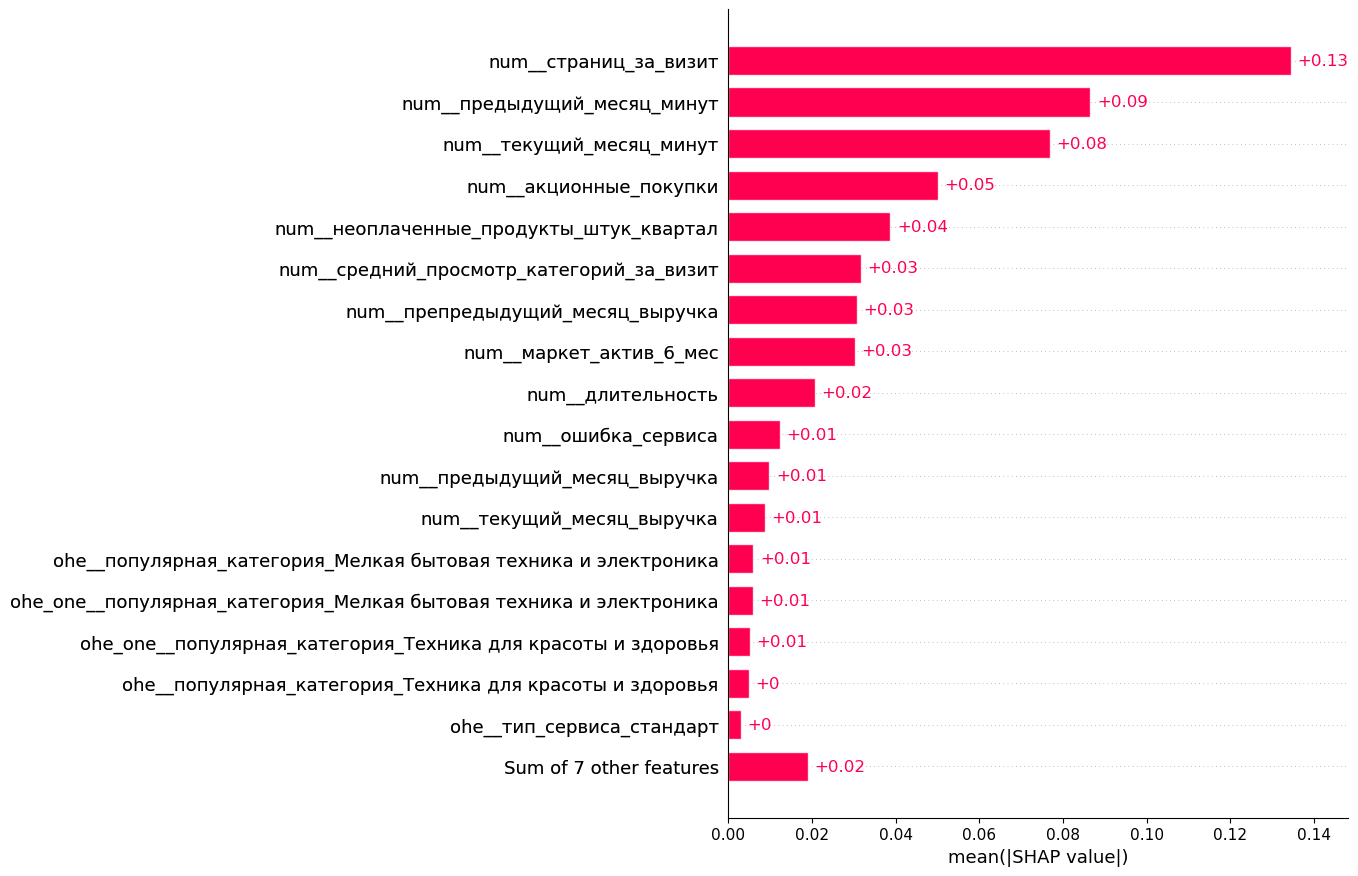

In [100]:
shap.plots.bar(shap_values_new, max_display=18)

_<span style='color: green;'>Наиболее важным признаком для предсказания покупательской активности является среднее количество страниц, которое просмотрел покупатель за один визит за последние 3 месяца.  
Второе и третье место занимают признаки со значениями времени, которое покупатель провел на сайте в течение предыдущего и текущего месяца.  
Акционные покупки (среднемесячная доля покупок по акции от общего числа покупок за последнии 6 месяцев) занимают четвертое место.
Девять признаков почти не влияют на предсказание: Категория, которую предпочитают покупатели, ошибки сервиса, выручка (предыдущий и текущий месяц) и тип сервиса не влияет на их покупательскую активность.</span>_ 

#### Влияние признаков на каждое предсказание модели

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


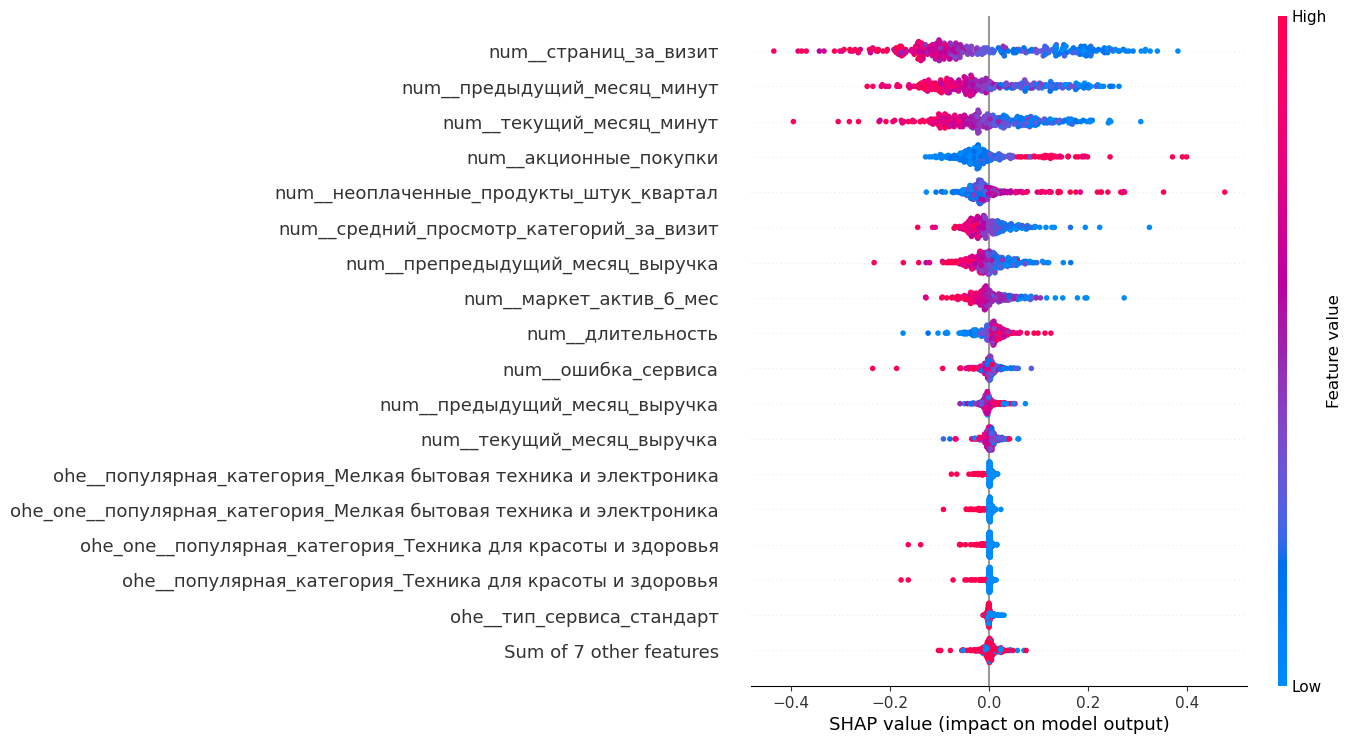

In [101]:
shap.plots.beeswarm(shap_values_new, max_display=18)

Шпаргалка: Преждней уровень - 0, Снизилась - 1

<span style='color: green;'>
    
_Увеличение значений признаков среднее количество страниц, которое просмотрел покупатель за один визит за последние 3 месяца, и время, которое покупатель провел на сайте в течение предыдущего и текущего месяца, склоняют модель к выбору категории прежднией уровень, понижение этих признаков приводит к выбору моделью категории снижение активности, данные закономерности выглядят логичными._  

_Интерес представляют признаки среднемесячная доля покупок по акции от общего числа покупок за последнии 6 месяцев и общее число неоплаченных товаров в корзине за последние 3 месяца. Их похожее влияние на то, какую категорию присваивает модель, может говорить о том, что покупатели откладывают товары в корзину в ожидании акций на них._  

_Еще один признак, на который возможно стоит обратить внимание, это длительность (сколько дней прошло с момента регистрации покупателя на сайте). Данный признак влияет на модель не сильно, но влияние на каждое предсказание, представляет интерес. Модель предсказывает снижение покупательской активности для покупателей, которые зарегистрировались давно._ 

_Несколько странным выглядит то, что модель более ориентируется на выручку, полученную от покупателя за предпредыдущий месяц, чем за предыдущий или текущий._

</span>

<span style='color: green;'>
    
Общий вывод для принятия бизнес решений:  
Хорошими показателями для мониторинга покупательской активности покупателей являюется их активность на сайте магазина (признаки, которые описывают поведение покупателя на сайте).  
Интерес представляет то, что участие в акционных покупках и общее число неоплаченных товаров в корзине связано с повышением вероятности снижения покупательской активности.  
Согласно модели, давность регистрации на сайте связано со снижением покупательской активности. Необходимо поддержать интерес давних покупателей.

</span>

### Шаг 8. Сегментация покупателей

Исходя из выводов модели, можно предположить, что есть некий сегмент покупателей, которые собирают много товаров в корзину и ждут, когда будет акция на эти товары. Важным является и то, что распределение акционных покупок, которое анализировалось в самом начале проекта, также содержит отдельную небольшую группу покупателей с высокой долей покупок по акции. Проверим эту гипотезу, попробуем найти этот сегмент и проанализировать его.

Будем работать с <font color='#FF&F50'>исходными данными</font>, ~~которая была тестовой для модели~~, для этого пересохраним данные в таблицу segment и добавим столбец с предсказаниями модели, который содержит вероятности снижения покупательской активности. Кроме того, добавим в таблицу данные о среднемесячной прибыли (какую прибыль получает магазин от продаж каждому покупателю) из таблицы money.

In [102]:
segment = df.drop(['покупательская_активность'], axis=1) # 

In [103]:
# получим значения вероятностей предсказания снижения активности.
y_predict_proba = randomized_search.predict_proba(segment) 


In [104]:
rounded_probabilities = np.round(y_predict_proba, 2) #округлим значения

In [105]:
segment['вероятность_снижения_покуп_активности'] = y_predict_proba[:, 1] # соединим все в одну таблицу

In [106]:
money.set_index('id', inplace=True, drop=True) 

In [107]:
segment = pd.merge(money, segment, left_index=True, right_index=True)

In [108]:
segment.head(5)

,index,прибыль,тип_сервиса,маркет_актив_6_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,вероятность_снижения_покуп_активности
id,,,,,,,,,,,,,,,,,
215349,1,4.16,премиум,4.4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0,0.980289
215350,2,3.13,стандарт,4.9,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0,0.632517
215351,3,4.87,стандарт,3.2,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0,0.825197
215352,4,4.21,стандарт,5.1,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0,0.976801
215353,5,3.95,стандарт,3.3,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0,0.866514


Построим корреляцию между количеством покупок по акции и вероятностью снижения покупательской активности; количеством отложенных товаров и вероятностью снижения покупательской активности.

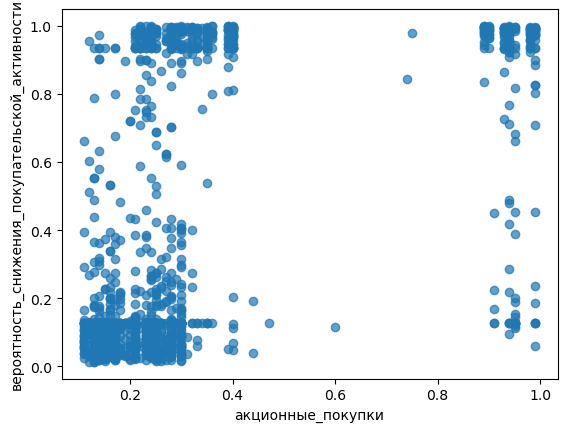

In [109]:
fig, ax = plt.subplots()
ax.scatter(segment['акционные_покупки'], segment['вероятность_снижения_покуп_активности'], marker = 'o', alpha = 0.7)
ax.set_xlabel('акционные_покупки')
ax.set_ylabel('вероятность_снижения_покупательской_активности')
plt.show()

_<span style='color: green;'> Четкой корреляции между двумя параметрами нет, но видно, что если значение акционных покупок больше 0.5, то большая часть клиентов показывает высокую вероятность снижения покупательской активности.</span>_ 

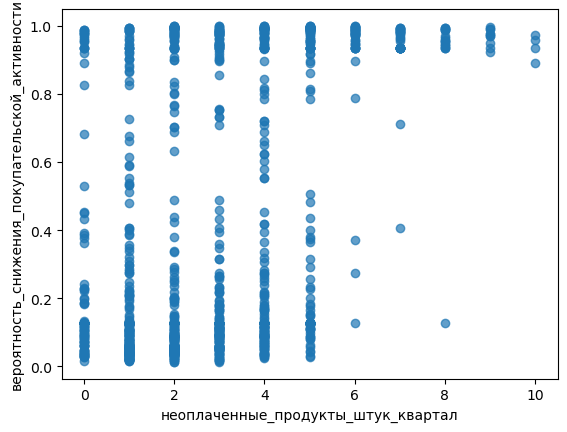

In [110]:
fig, ax = plt.subplots()
ax.scatter(segment['неоплаченные_продукты_штук_квартал'], segment['вероятность_снижения_покуп_активности'], marker = 'o', alpha = 0.7)
ax.set_xlabel('неоплаченные_продукты_штук_квартал')
ax.set_ylabel('вероятность_снижения_покупательской_активности')
plt.show()

_<span style='color: green;'>Исходное предположение оказалось не совсем верным. У покупателей с высокой вероятность снижения покупательской активности может быть разное количество товаров в корзине.</span>_ 

#### Выделим покупателей у которых вероятность снижения покупательской активности больше 0.7 и проанализируем этих покупателей.

In [111]:
filtered_segment = segment.loc[segment['вероятность_снижения_покуп_активности']>=0.7]


In [112]:
filtered_segment.head(4)

,index,прибыль,тип_сервиса,маркет_актив_6_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,вероятность_снижения_покуп_активности
id,,,,,,,,,,,,,,,,,
215349,1,4.16,премиум,4.4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0,0.980289
215351,3,4.87,стандарт,3.2,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0,0.825197
215352,4,4.21,стандарт,5.1,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0,0.976801
215353,5,3.95,стандарт,3.3,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0,0.866514


Проанализируем признаки покупателей, у которых вероятность снижения покупательской активности больше 0.7.

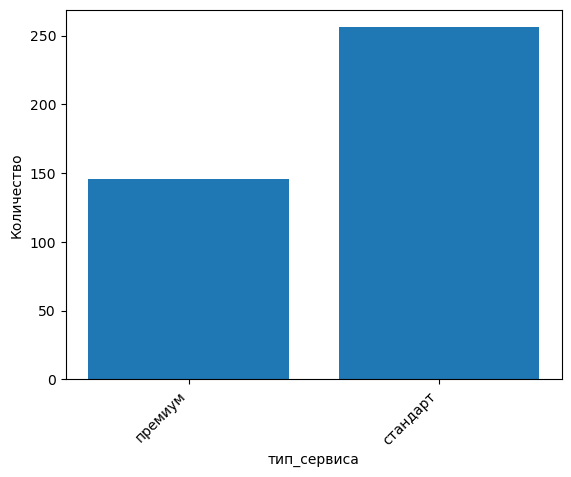

In [113]:
plot_bar(filtered_segment, 'тип_сервиса') # используем ранее написанную функцию

_<span style='color: green;'>В данную группу попадает больше покупателей, которые не пользуются премиум сервисом.</span>_

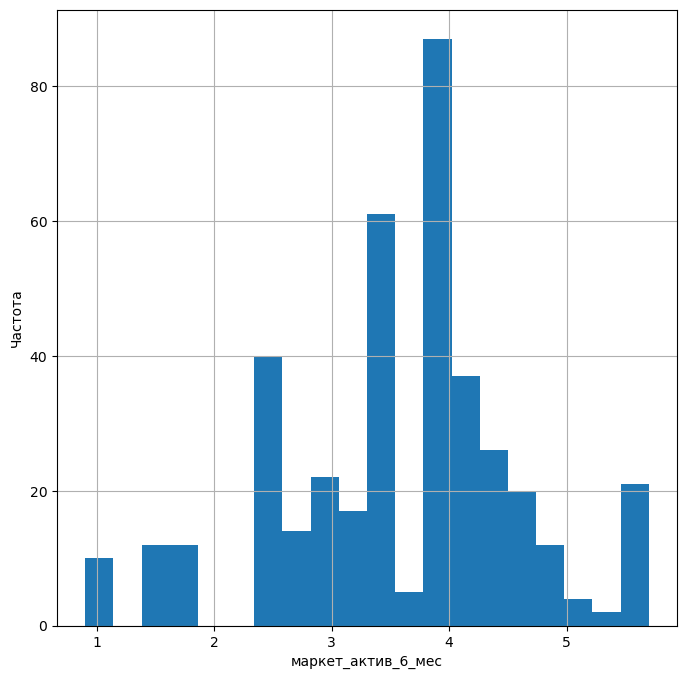

In [114]:
plot_histogram(filtered_segment, 'маркет_актив_6_мес', bins=20) # используем ранее написанную функцию

_<span style='color: green;'>В данную группу попадают покупатели, на которых приходилось в среднем от 3 до 5 маркетинговых коммуникаций компании.</span>_

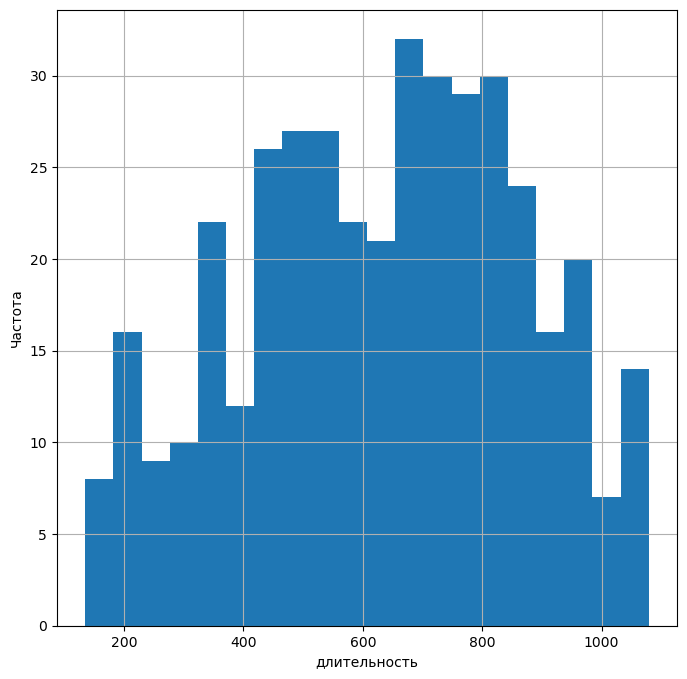

In [115]:
plot_histogram(filtered_segment, 'длительность', bins=20) # используем ранее написанную функцию

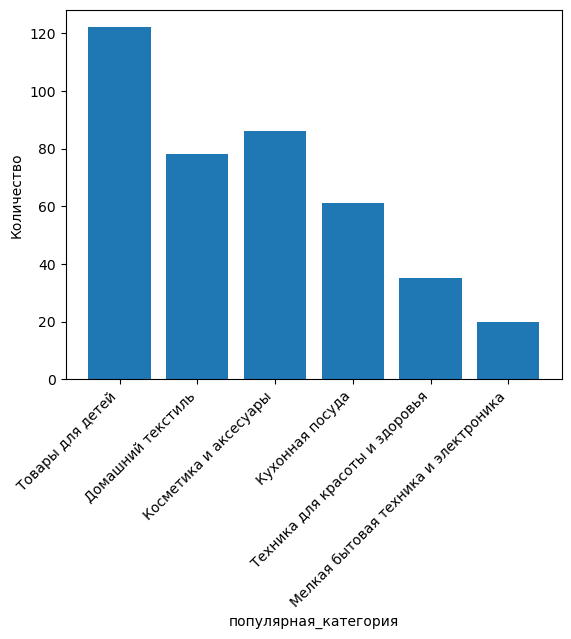

In [116]:
plot_bar(filtered_segment, 'популярная_категория') # используем ранее написанную функцию

_<span style='color: green;'>Покупатели из выбранного среза данных больше всего покупают товары для детей, меньше всего бытовую технику и электроннику.</span>_

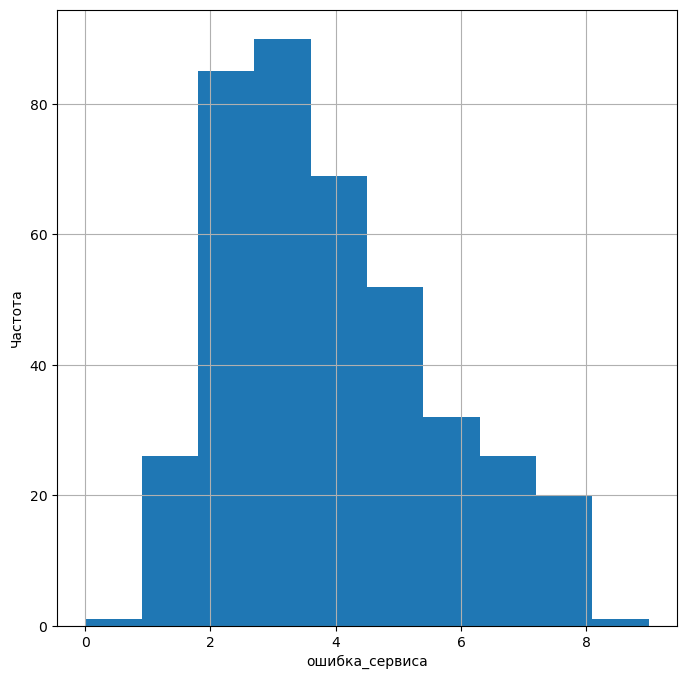

In [117]:
plot_histogram(filtered_segment, 'ошибка_сервиса', bins=10) # используем ранее написанную функциюошибка_сервиса

_<span style='color: green;'>Интересно, что в данной категории больше покупателей, которые сталкивались с 2-3 сбоями сайта.</span>_

#### Изучим как меняется выручка, получаемая от таких покупателей за три месяца.

In [118]:
sums = filtered_segment[['препредыдущий_месяц_выручка', 'предыдущий_месяц_выручка', 'текущий_месяц_выручка']].mean()

In [119]:
std_devs = filtered_segment[['препредыдущий_месяц_выручка', 'предыдущий_месяц_выручка', 'текущий_месяц_выручка']].std()

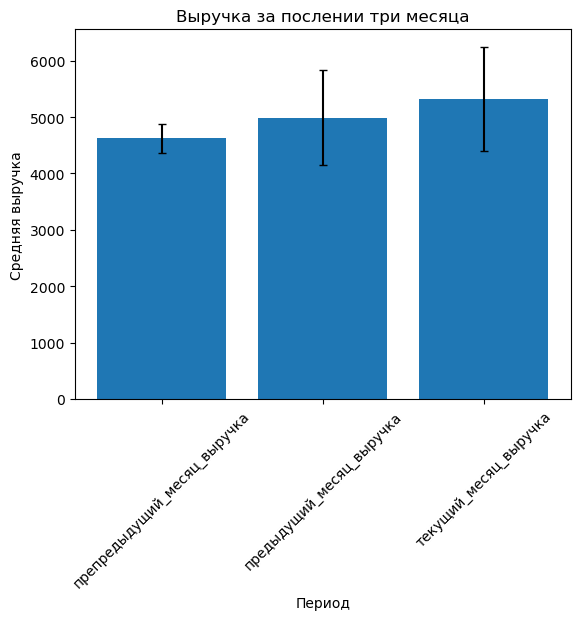

In [120]:
fig, ax = plt.subplots()
ax.bar(sums.index, sums.values, yerr=std_devs, capsize=3) 
plt.title('Выручка за послении три месяца')
plt.xlabel('Период')
plt.xticks(rotation=45)
plt.ylabel('Средняя выручка')
plt.show()

_<span style='color: green;'>Кажется, что средняя выручка увеличивается, но с таким перекрытием стандартных отклонений, это увеличение скорее всего не достоверно.</span>_

In [121]:
sums2 = filtered_segment[['предыдущий_месяц_минут', 'текущий_месяц_минут']].mean()

std_devs2 = filtered_segment[['предыдущий_месяц_минут', 'текущий_месяц_минут']].std()


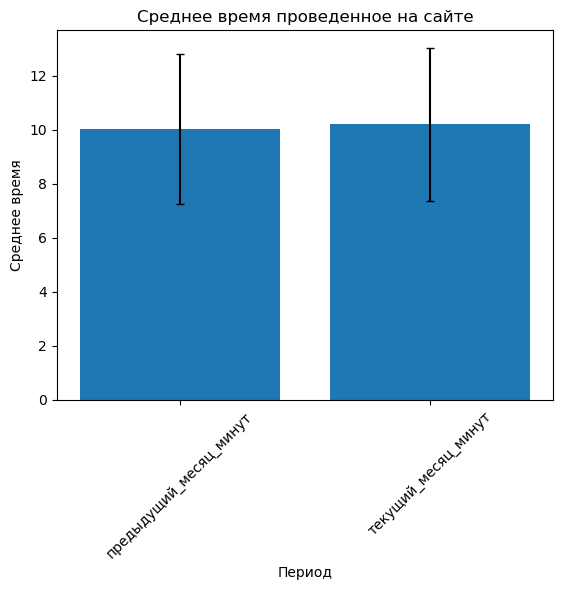

In [122]:
fig, ax = plt.subplots()
ax.bar(sums2.index, sums2.values, yerr=std_devs2, capsize=3) 
plt.title('Среднее время проведенное на сайте')
plt.xlabel('Период')
plt.xticks(rotation=45)
plt.ylabel('Среднее время')
plt.show()

_<span style='color: green;'>Среднее время проведенное на сайте не изменилось.</span>_

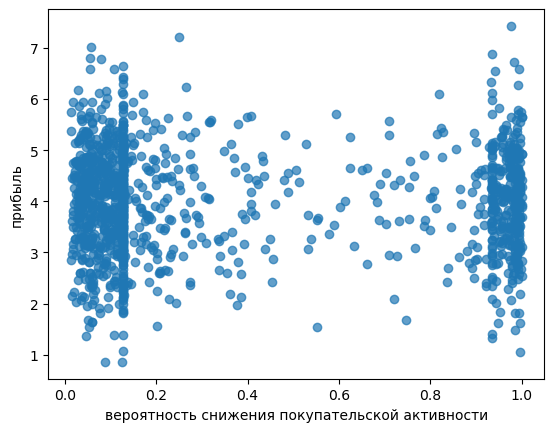

In [123]:
fig, ax = plt.subplots()
ax.scatter(segment['вероятность_снижения_покуп_активности'], segment['прибыль'], marker = 'o', alpha = 0.7)
ax.set_xlabel('вероятность снижения покупательской активности')
ax.set_ylabel('прибыль')
plt.show()

_<span style='color: green;'>Данные о среднемесячной прибыли распределены схоже для покупателей с вероятность снижения покупательской активности ниже 0.7 и выше о.7.</span>_

<span style='color: green;'>
Вывод.
    
Проанализировав группу покупателей, для которых модель показала вероятность снижения покупательской активности больше 0.7, можно сделать следующие выводы-предложения:

* Необходимо стимулировать покупателей переходить на премиальный тип сервиса. Активность снижается у покупателей со стандартным уровнем сервиса. Объявим скидку на премиум!
* Маркетинговая коммуникация, видимо, работает не так хорошо. На клиентов со снижающейся покупательской активностью приходится 3 - 4 маркетинговых коммуникации. Возможно, надо продумывать более персонализированные предложения.
* Данные покупатели больше покупают товары для детей, домашний текстиль, коcметику и аксесуары. Можно проводить больше акций, связанных с данными товарами. Кроме того, можно соотнести категории, т.е. если покупателей из данного среза больше интересуют товары для детей. предлагать им мелкую бытовую технику и электронику, связанную с детьми.
* Выручка, полученная от данных клиентов за послении три месяца, сильно не отличается. Время, проведенное на сайте, можно считать одинаковым.
</span>

#### Исследование сегмента покупателей, построенного по двум признакам: вероятность снижения покупательской активности и среднемесячная прибыль.  

При таком разделении можно выделить следующие сегменты: 

* Покупатели, приносящие высокую прибыль и имеющие высокую вероятность снижения покупательской активности (покупатели, которых необходимо сохранить)
* Покупатели, приносящие высокую прибыль и имеющие низкую вероятность снижения покупательской активности (наиболее ценные покупатели)
* Покупатели, приносящие низкую прибыль и имеющие высокую вероятность снижения покупательской активности (покупатели, которых будет не так жалко терять)
* Покупатели, приносящие низкую прибыль и имеющие низкую вероятность снижения покупательской активности
* Средняя группа со средней прибылью и средней вероятность снижения покупательской активности.

В данном проекте для анализа возьмем первую группу.  
Для того, чтобы разделить данные на сегменты, необходимо выбрать порог разделения. В качесте порога возьмем среднее значение плюc стандартное отклонение.

In [124]:
segment.describe()

,index,прибыль,маркет_актив_6_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,вероятность_снижения_покуп_активности
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,650.986893,3.997610,4.254433,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584,4948.339630,4836.367772,5238.347340,13.469545,13.211257,0.385677
std,374.578554,1.010813,1.015618,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061,701.228571,333.438742,834.045867,3.936323,4.220222,0.391454
min,1.000000,0.860000,0.900000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,2758.700000,5.000000,4.000000,0.012943
25%,327.000000,3.300000,3.700000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000,4498.500000,4585.000000,4706.600000,11.000000,10.000000,0.084732
50%,651.000000,4.040000,4.200000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000,5005.500000,4812.000000,5180.300000,13.000000,13.000000,0.128030
75%,975.000000,4.670000,4.900000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000,5409.000000,5055.000000,5758.600000,17.000000,16.000000,0.934596
max,1299.000000,7.430000,6.600000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,23.000000,23.000000,0.999996


Средняя прибыль составляет 4, стандартное отклонение 1.  
Средняя вероятность снижения покупательской активности состаляет 0.4, а стандартное отклонение 0.4.  

** после такого разделения очень мало покупателей попало в анализ, поэтому далее взял среднее значенеи прибыли, т.е. в анализ пошла группа покупателей, прибыль от которых выше среднего.

In [125]:
two_filt_segment = segment.loc[(segment['вероятность_снижения_покуп_активности']>=0.8)&(segment['прибыль']>=4)]

Построим диаграмму расеяния, чтобы визуализировать выделенный нами сегмент данных.

In [126]:
merged = segment.merge(two_filt_segment, how='left', indicator=True) #преобразования для построения графика
temp = merged[merged['_merge'] == 'left_only']
temp = temp.drop(columns=['_merge'])

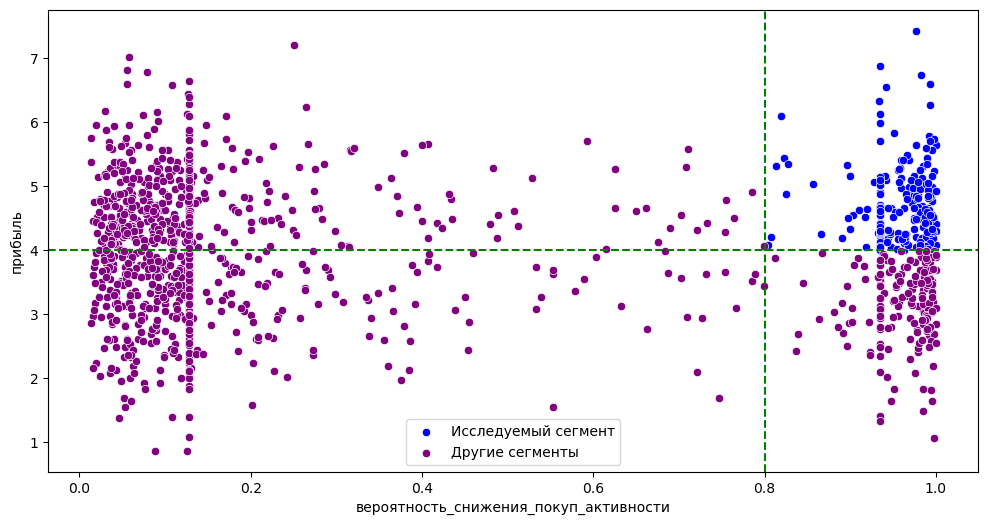

In [127]:
plt.figure(figsize=(12,6))
sb.scatterplot(data=two_filt_segment, x='вероятность_снижения_покуп_активности', y='прибыль', label= 'Исследуемый сегмент', color='blue')
sb.scatterplot(data=temp, x='вероятность_снижения_покуп_активности', y='прибыль', label= 'Другие сегменты', color='purple')
plt.legend()
plt.axvline(x=0.8, color='green', linestyle='--')
plt.axhline(y=4, color='green', linestyle='--')
plt.show()

Из данного сегмента выделим группу покупателей, которых интересуют прежде всего товары для детей.  
Проведем исследование этой группы.

In [128]:
kids_product = two_filt_segment.loc[two_filt_segment['популярная_категория'] == 'Товары для детей']

In [129]:
merged2 = two_filt_segment.merge(kids_product, how='left', indicator=True)
all_other = merged2[merged2['_merge'] == 'left_only']
all_other = all_other.drop(columns=['_merge']) # таблица где все без kids_product

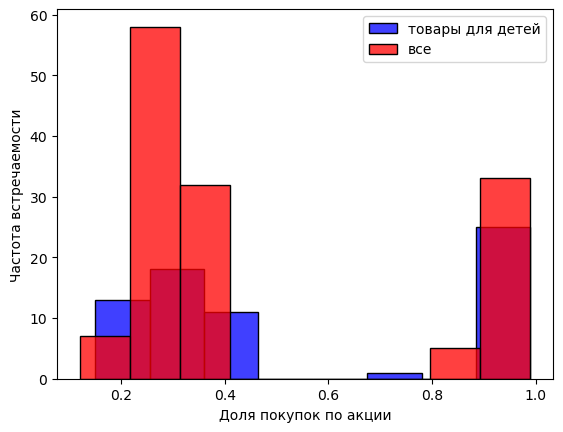

In [130]:
sb.histplot(kids_product['акционные_покупки'], label='товары для детей', element='bars', stat='count', color='blue')
sb.histplot(all_other['акционные_покупки'], label='все', element='bars', stat='count', color='red')
plt.xlabel('Доля покупок по акции')
plt.ylabel('Частота встречаемости')
plt.legend()
plt.show()

_<span style='color: green;'>Для покупателей, покупающих товары для детей, не видно какой-нибудь особенности в участии в акциях. Распределение для всех покупателей из сегмента и для покупателей, выбирающих товары для детей схоже.</span>_

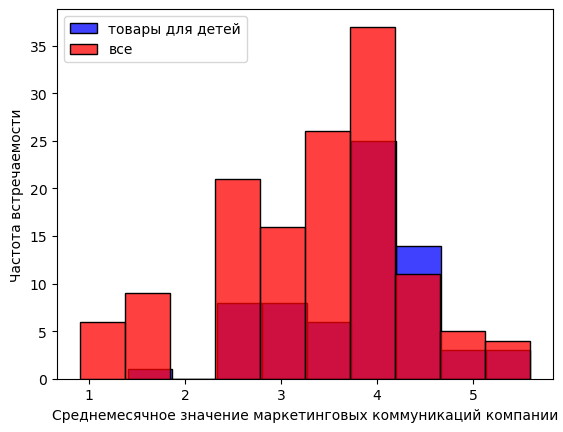

In [131]:
sb.histplot(kids_product['маркет_актив_6_мес'], label='товары для детей', element='bars', stat='count', color='blue')
sb.histplot(all_other['маркет_актив_6_мес'], label='все', element='bars', stat='count', color='red')
plt.xlabel('Среднемесячное значение маркетинговых коммуникаций компании')
plt.ylabel('Частота встречаемости')
plt.legend()
plt.show()

_<span style='color: green;'>Покупатели, выбирающие товары для детей, получают достаточно много рекламы. Возможно, реклама содержит мало предложений с товарами интересными данной группе покупателей. Реклама плохо таргетирована?</span>_

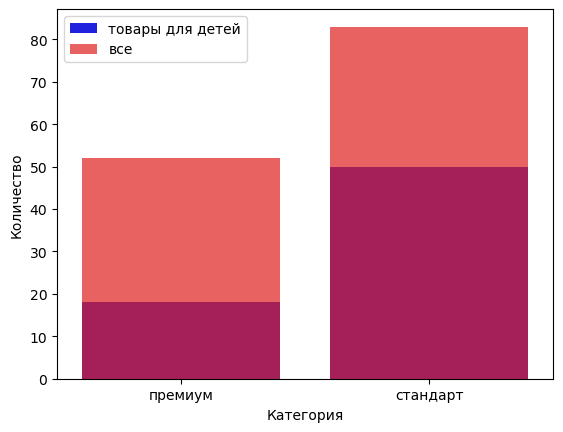

In [132]:
sb.countplot(x='тип_сервиса', data=kids_product, color='blue', label='товары для детей')
sb.countplot(x='тип_сервиса', data=all_other, color='red', label='все', alpha=0.7)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.legend()
plt.show()

_<span style='color: green;'>Покупатели, выбирающие товары для детей, используют премиум аккаунт, но наличие премиум статуса не мотивирует их дальше покупать. Надо проанализировать, какие приимушества дает премиум статус, возможно, надо что-то добавить, привязав это к предпочитаемой категории.</span>_

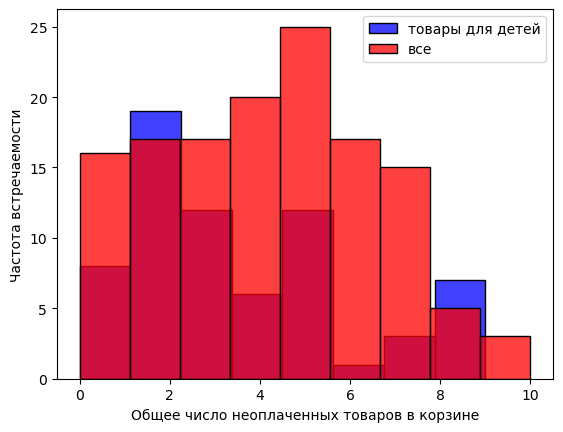

In [133]:
sb.histplot(kids_product['неоплаченные_продукты_штук_квартал'], label='товары для детей', element='bars', stat='count', color='blue')
sb.histplot(all_other['неоплаченные_продукты_штук_квартал'], label='все', element='bars', stat='count', color='red')
plt.xlabel('Общее число неоплаченных товаров в корзине')
plt.ylabel('Частота встречаемости')
plt.legend()
plt.show()

_<span style='color: green;'>Распределение выбранной категории укладывается в распределение сегмента, но есть некоторый "выброс" покупателей, которые держат в корзине больше 8 товаров. Так как это товары для детей, возможно, они понадобятся в будущем, поэтому они в корзине в ожидании акции.</span>_

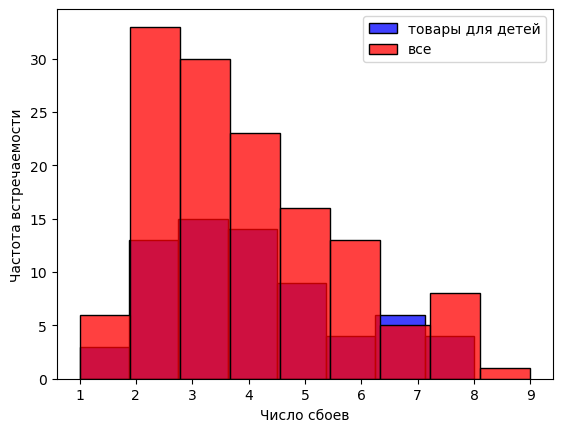

In [134]:
sb.histplot(kids_product['ошибка_сервиса'], label='товары для детей', element='bars', stat='count', color='blue')
sb.histplot(all_other['ошибка_сервиса'], label='все', element='bars', stat='count', color='red')
plt.xlabel('Число сбоев')
plt.ylabel('Частота встречаемости')
plt.legend()
plt.show()

_<span style='color: green;'>Распределения совпадают, со сбоями сталкиваются все.</span>_

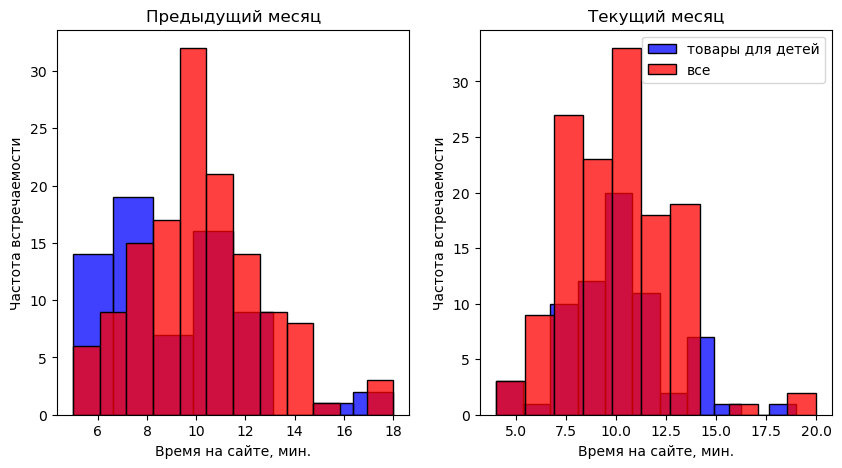

In [135]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sb.histplot(kids_product['предыдущий_месяц_минут'], label='товары для детей', element='bars', stat='count', color='blue', ax=ax[0])
sb.histplot(all_other['предыдущий_месяц_минут'], label='все', element='bars', stat='count', color='red', ax=ax[0])
sb.histplot(kids_product['текущий_месяц_минут'], label='товары для детей', element='bars', stat='count', color='blue', ax=ax[1])
sb.histplot(all_other['текущий_месяц_минут'], label='все', element='bars', stat='count', color='red', ax=ax[1])
ax[0].set_title('Предыдущий месяц')
ax[1].set_title('Текущий месяц')
ax[0].set_xlabel('Время на сайте, мин.')
ax[1].set_xlabel('Время на сайте, мин.')
ax[0].set_ylabel('Частота встречаемости')
ax[1].set_ylabel('Частота встречаемости')
plt.legend()
plt.show()

_<span style='color: green;'>В предыдущий месяц покупатели товаров для детей проводили меньше времени на сайте. В текущем месяце им надо больше времени. Со стороны магазина, возможно, что-то поменялось в поисковой системе сайта.</span>_

### Шаг 9. Общий вывод

Задачей проекта было разработать модель, которая будет предсказывать вероятность снижения покупательской активности в интернет-магазине "В один клик". Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность.

Для решения поставленной задачи магазин предоставил данные, которые можно разделить на следующие группы:
Признаки, которые описывают коммуникацию сотрудников компании с клиентом.  
Признаки, которые описывают продуктовое поведение покупателя.  
Признаки, которые описывабт покупательское поведение клиента.  
Признаки, которые описывают поведение покупателя на сайте.

Предобработка данных показала:
* что в компании при сборе данных используются разные разделители данных и разные разделители для десятичных дробей
* необходимость стандартизировать название колонок в данных
* пропущенные значения в данных отсутствуют
* есть неявные дубликаты в данных

Исследовательский анализ данных показал:
* большая часть данных имеет распределение, приближенное к нормальному, но не везде (акционные покупки)
* данные по выручке, полученной от покупателей, содержали  выбросы
* данные по клиентам, которые не совершали покупок, хотя бы в один из месяцев были удалены
* целевой признак представлен в данных не в равных пропорциях

После объядинения таблиц был проведен корреляционный анализ:
* мультиколлениарность обнаружена не была
* на основе двух количественных признаков была попытка создать новые категориальные признаки, но новые признаки коррелировали с целевым признаком хуже и были удалены.
* корреляция выявила два признака, корреляция который с целевым признаком стремиласт к нулю, данные признаки были удалены.

Для поиска лучшей модели был создан пайплайн, в котором происходил перебор четырех вариантов моделей с разными гиперпараметрами. Использовалась кросс валидация. В качестве метрики качества была выбрана roc_auc.

Лучшая модель: модель опорных векторов (SVC) с ядром радиально-базисной функции (rbf) и с коэфициентом регуляризации 2. Данная модель показала не только лучшее значение метрики качества, но и минимальное значение стандартного отклонения.

Анализ важности признаков показал, что наибольшее значение имеют признаки, которые описывают поведение покупателя на сайте. 

Для анализа был выбран сегмент покупателей, чья вероятность снижения покупательской активности больше 0.7.
Анализ сегмента позволил сделать следующие выводы:
* Необходимо стимулировать покупателей переходить на премиальный тип сервиса. Активность снижается у покупателей со стандартным уровнем сервиса. Объявим скидку на премиум!
* Маркетинговая коммуникация, видимо, работает не так хорошо. На клиентов со снижающейся покупательской активностью приходится 3 - 4 маркетинговых коммуникации. Возможно, надо продумывать более персонализированные предложения.
* Данные покупатели больше покупают товары для детей, домашний текстиль, кометику и аксессуары. Можно проводить больше акций, связанных с данными товарами. Кроме того, можно соотнести категории, т.е. если покупателей из данного среза больше интересуют товары для детей, предлагать им мелкую бытовую технику и электронику, связанную с детьми.
* Выручка, полученная от данных клиентов, за послении три месяца сильно не отличается. Время, проведенное на сайте, можно считать одинаковым.

Добавим в общий вывод результаты анализа группы покупателей, которые выбирают товары для детей, из сегмента, который приносит прибыль выше среднего, но склонен к высокой вероятности снижения покупательской активности.

* Анализ выявил возможные проблемы с рекламой. Возможно, реклама не достаточна таргетирована и покупатели получают рекламу о продуктах из категорий, которые им не интересны.
* Из выбранной группы большая часть клиентов имеет премиум статус. Возможно премиум статус стал не столь выгоден клиентам. Стоит обратить внимание на бонусы, которые дает такой статус.
* Изменилось время, которое данная группа проводит на сайте. Возможно, что-то поменялось в структуре сайта или поиска. Другой вариант, продолжительность пребывания на сайте связано с сезонной актуальностью товаров для детей (осень,перед школой; зимой, перед новым годом, и пр.)

1111